
# 实现线性回归

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import torch
%matplotlib inline

## 生成数据集

In [3]:
num_inputs = 2 # 输入特征数 2
num_examples = 1000 # 1000个样本
true_w = [2, -3.4]  # 线性回归的真实权重
true_b = 4.2   # 偏差

# 100 row 2 col
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)

labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1]

# 噪声项 服从 均值为 0  标准差为 0.01 的正态分布  噪声项代表无意义的干扰
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

print(features[0], labels[0])   # 查看结构

tensor([-0.4307, -0.8974]) tensor(2.1851)


C:\Users\zonglin\AppData\Local\Temp/ipykernel_4868/942839298.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


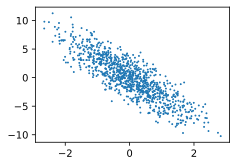

In [5]:
def use_svg_display():
    # 使用 svg 展示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:,1].numpy(), labels.numpy(), 1)

## 读取数据

In [15]:
# 训练模型时 需要遍历数据集并不断读取小批量数据样本
# 该函数每次返回 batch_size 批量大小个随机样本的特征和标签 也就是把样本分成 batch_size 份
def data_iter(batch_size, features, labels):
    num_examples = len(features)            # 获取样本总数
    indices = list(range(num_examples))     # 生成样本总数的一个索引 例如 [0,1,2,...,num_example-1]
    # print("indices:", indices)
    random.shuffle(indices)                 # 样本读取顺序是随机的 所以使用 shuffle 进行打乱
    for i in range(0, num_examples, batch_size):    # 步长为 batch_size
        # j 是一个序列 由于 indices 已经打乱 所以可以顺序截取
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])   # 最后一次可能不足一个batch
        # print(j)    # 如 [761, 432, 254, 417, 367,   6, 540, 955, 328,  15]
        yield features.index_select(0, j), labels.index_select(0, j)

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-1.0614, -0.5868],
        [ 0.4449, -1.7353],
        [-0.7080,  1.5177],
        [ 0.2598,  1.0685],
        [-0.1338, -0.0508],
        [-1.8779, -1.5234],
        [-0.0824, -1.5489],
        [-0.0811,  0.0122],
        [-1.4954,  0.2317],
        [-1.0178, -0.5977]]) tensor([-1.4738e-01,  6.7804e+00, -6.5805e+00, -3.1189e+00, -1.0496e-01,
         1.4197e+00,  5.1098e+00, -1.8578e-01, -3.7800e+00, -6.4165e-03])


## 初始化模型参数

In [17]:
# 权重初始化为： 均值 0  标准差 0.01 的正态随机数 偏差初始化为0
# 权重为 2 行 1 列 (num_inputs, 1) 对应要输入两个特征
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
print(w)
print(b)

tensor([[0.0190],
        [0.0196]])
tensor([0.])


之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的`requires_grad=True`。

In [18]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 定义模型
下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。

In [19]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

## 定义损失函数
使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [21]:
def square_loss(y_hat, y):
    # 这里返回的是向量 pytorch 中 MSELoss 没有除以2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 定义优化算法
实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [20]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size  # 注意这里更改param时用的param.data

## 模型训练
多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，**大多超参数都需要通过反复试错来不断调节**。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [ ]:
lr = 0.03       # 学习率
num_epochs = 3  # 迭代轮次
net = linreg
loss = square_loss

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum() # l是有关小批量X和y的损失
        l.backward()                    # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)     # 使用小批量随机梯度下降迭代模型参数 每次迭代中更新权重和偏差

        # 不要忘记 梯度清零